In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
library(ggplot2)
library(ggpubr)
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  }else{return('black')}
}

Warning message:
“package ‘plyr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”

Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




In [2]:

color_annotation <- read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [3]:
df<-read.csv('02_NMF_CD4_T_cell_Projection/NMF_Scores_Y1D0_BRI.csv')
meta_data=read.csv("../Dataset/scRNA_meta_data-2024-05-09.csv")


In [4]:
df_filtered<-df %>% filter(AIFI_L3=='CM CD4 T cell',NMF_Scores=='NMF6_Tfh')%>% ungroup()

In [5]:
df_filtered<-left_join(df_filtered,meta_data,by=c('pbmc_sample_id'))

In [6]:
df_filtered<-df_filtered %>% mutate(`Age Group`=case_when(cohort.cohortGuid=="BR1"~"Young", TRUE~'Older'))
df_filtered$`Age Group`<-factor(df_filtered$`Age Group`,levels=c("Young","Older"))

In [7]:
df_filtered$AIFI_L3<-gsub(" cell","",df_filtered$AIFI_L3)

In [11]:

write.csv(df_filtered  %>% select(subject.subjectGuid,AIFI_L3,`Age Group`,AverageScore),
          "/home//workspace/Source_Data/Extended_Fig8b.csv",row.names=FALSE)

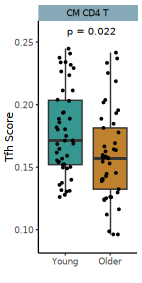

In [10]:
options(repr.plot.width = 30/25.4, repr.plot.height = 60/25.4)

p<-ggplot(df_filtered, aes(x=`Age Group`, y=AverageScore, fill=`Age Group`)) +
    geom_boxplot(outlier.shape = NA,lwd=0.3) +
geom_point(position = position_jitter(width = 0.2),color="black", size=0.8,stroke=0) +
theme_classic(base_size=6)+  
stat_compare_means(aes(label = paste0("p = ", after_stat(p.format))),
    size=2,
    label.x=1.25,  
    vjust = -2)+theme(strip.background = element_rect(linewidth = 0))+
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0.1, 0.15)))+
theme(legend.position="none")+
xlab('')+
ylab('Tfh Score')+
facet_wrap(~AIFI_L3,  scale='free_y') 

g <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', g$layout$name))

pal <- color_vector['CM CD4 T cell']
text_color <- sapply(color_vector['CM CD4 T cell'], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl('rect', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  g$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <-  adjustcolor(pal[i], alpha.f = 0.8)
  g$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(g)

ggsave('FigureB.pdf',g,width = 30/25.4,height = 60/25.4)